In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json
csv_path = '/home/dhruv/Weather_Prediction/train.csv'

In [14]:
def load_and_preprocess_data(csv_path, sequence_length=10):
    """
    Load CSV data and prepare it for training with sequences for RNN/GRU.
    
    Expected CSV format:
    pressure,temparature,humidity,rainfall
    1017.4,20.6,87.0,1
    1019.5,16.9,95.0,1
    ...
    """
    # Load the data
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} samples from {csv_path}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Extract features and target
    X = df[['pressure', 'temparature', 'humidity']].values
    y = df['rainfall'].values.reshape(-1, 1)
    
    # Check for missing values
    if np.isnan(X).any() or np.isnan(y).any():
        print("Warning: Dataset contains NaN values. Removing them...")
        mask = ~(np.isnan(X).any(axis=1) | np.isnan(y).flatten())
        X = X[mask]
        y = y[mask]
        print(f"Remaining samples: {len(X)}")
    
    # Basic statistics
    print(f"\nData statistics:")
    print(f"Pressure range: {X[:, 0].min():.2f} to {X[:, 0].max():.2f}")
    print(f"Temperature range: {X[:, 1].min():.2f} to {X[:, 1].max():.2f}")
    print(f"Humidity range: {X[:, 2].min():.2f} to {X[:, 2].max():.2f}")
    print(f"Rainfall range: {y.min():.2f} to {y.max():.2f}")
    
    return X, y

def create_sequences(X, y, sequence_length=10):
    """
    Create sequences from the data for RNN/GRU models.
    
    Args:
        X: Feature array of shape (n_samples, n_features)
        y: Target array of shape (n_samples, 1)
        sequence_length: Length of each sequence
    
    Returns:
        X_seq: Sequences of shape (n_sequences, sequence_length, n_features)
        y_seq: Targets of shape (n_sequences, 1)
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - sequence_length + 1):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length-1])
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    print(f"\nCreated sequences:")
    print(f"Sequence length: {sequence_length}")
    print(f"Number of sequences: {len(X_seq)}")
    print(f"X_seq shape: {X_seq.shape}")
    print(f"y_seq shape: {y_seq.shape}")
    
    return X_seq, y_seq



In [15]:
def create_scalers(X, y):
    """
    Create and fit MinMaxScalers for features and target.
    """
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)
    
    return X_scaler, y_scaler, X_scaled, y_scaled

In [16]:
class RainfallGRU(nn.Module):
    """
    GRU-based neural network for rainfall prediction.
    Architecture: 3 input features -> GRU(8) -> GRU(4) -> Linear(1)
    """
    def __init__(self, input_size=3, hidden_size1=8, hidden_size2=4, num_layers=1):
        super(RainfallGRU, self).__init__()
        # First GRU layer: 3 input features -> 8 hidden units
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1, 
                           num_layers=num_layers, batch_first=True)
        # Second GRU layer: 8 -> 4 hidden units
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2,
                           num_layers=num_layers, batch_first=True)
        # Output layer: 4 -> 1 output
        self.output = nn.Linear(hidden_size2, 1)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        # First GRU layer
        gru1_out, _ = self.gru1(x)  # (batch_size, sequence_length, hidden_size1)
        # Second GRU layer
        gru2_out, _ = self.gru2(gru1_out)  # (batch_size, sequence_length, hidden_size2)
        # Take the last output from the sequence
        last_output = gru2_out[:, -1, :]  # (batch_size, hidden_size2)
        # Final output
        output = self.output(last_output)  # (batch_size, 1)
        return output


class RainfallRNN(nn.Module):
    """
    RNN-based neural network for rainfall prediction.
    Architecture: 3 input features -> RNN(8) -> RNN(4) -> Linear(1)
    """
    def __init__(self, input_size=3, hidden_size1=8, hidden_size2=4, num_layers=1):
        super(RainfallRNN, self).__init__()
        # First RNN layer: 3 input features -> 8 hidden units
        self.rnn1 = nn.RNN(input_size=input_size, hidden_size=hidden_size1,
                          num_layers=num_layers, batch_first=True)
        # Second RNN layer: 8 -> 4 hidden units
        self.rnn2 = nn.RNN(input_size=hidden_size1, hidden_size=hidden_size2,
                          num_layers=num_layers, batch_first=True)
        # Output layer: 4 -> 1 output
        self.output = nn.Linear(hidden_size2, 1)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        # First RNN layer
        rnn1_out, _ = self.rnn1(x)  # (batch_size, sequence_length, hidden_size1)
        # Second RNN layer
        rnn2_out, _ = self.rnn2(rnn1_out)  # (batch_size, sequence_length, hidden_size2)
        # Take the last output from the sequence
        last_output = rnn2_out[:, -1, :]  # (batch_size, hidden_size2)
        # Final output
        output = self.output(last_output)  # (batch_size, 1)
        return output


In [17]:
# Example usage of GRU and RNN models
# Load and preprocess data
X, y = load_and_preprocess_data(csv_path)

# Scale the data first (before creating sequences)
X_scaler, y_scaler, X_scaled, y_scaled = create_scalers(X, y)

# Create sequences for RNN/GRU (default sequence_length=10)
sequence_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length=sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_seq)
y_tensor = torch.FloatTensor(y_seq)

# Split into train and test sets
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# GRU Model
gru_model = RainfallGRU(input_size=3, hidden_size1=8, hidden_size2=4).to(device)
print(f"\nGRU Model created:")
print(gru_model)

# RNN Model
rnn_model = RainfallRNN(input_size=3, hidden_size1=8, hidden_size2=4).to(device)
print(f"\nRNN Model created:")
print(rnn_model)


Loaded 2190 samples from /home/dhruv/Weather_Prediction/train.csv
Columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']

First few rows:
   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6    

In [20]:
def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001, model_name="Model"):
    """
    Train a model and return training history.
    """
    device = next(model.parameters()).device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
    
    print(f"\nTraining completed!")
    print(f"Final Train Loss: {train_losses[-1]:.6f}")
    print(f"Final Test Loss: {test_losses[-1]:.6f}")
    
    return train_losses, test_losses

def evaluate_model(model, test_loader, y_scaler):
    """
    Evaluate model and return predictions and metrics.
    """
    device = next(model.parameters()).device
    model.eval()
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            
            # Inverse transform to get original scale
            pred_np = outputs.cpu().numpy()
            actual_np = batch_y.numpy()
            
            # Inverse transform using scaler
            pred_original = y_scaler.inverse_transform(pred_np)
            actual_original = y_scaler.inverse_transform(actual_np)
            
            predictions.extend(pred_original)
            actuals.extend(actual_original)
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate metrics
    mse = np.mean((predictions - actuals) ** 2)
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(mse)
    
    print(f"\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return predictions, actuals, {'mse': mse, 'mae': mae, 'rmse': rmse}


In [21]:
# Train GRU Model
print("\n" + "="*60)
print("TRAINING GRU MODEL")
print("="*60)

gru_train_losses, gru_test_losses = train_model(
    gru_model, 
    train_loader, 
    test_loader, 
    num_epochs=50, 
    learning_rate=0.001,
    model_name="GRU"
)



TRAINING GRU MODEL

Training GRU
Epoch [1/50] - Train Loss: 0.565813, Test Loss: 0.290250
Epoch [10/50] - Train Loss: 0.186794, Test Loss: 0.162910
Epoch [20/50] - Train Loss: 0.166400, Test Loss: 0.143270
Epoch [30/50] - Train Loss: 0.150955, Test Loss: 0.136999
Epoch [40/50] - Train Loss: 0.148282, Test Loss: 0.137372
Epoch [50/50] - Train Loss: 0.147243, Test Loss: 0.137242

Training completed!
Final Train Loss: 0.147243
Final Test Loss: 0.137242


In [22]:
# Train RNN Model
print("\n" + "="*60)
print("TRAINING RNN MODEL")
print("="*60)

rnn_train_losses, rnn_test_losses = train_model(
    rnn_model, 
    train_loader, 
    test_loader, 
    num_epochs=50, 
    learning_rate=0.001,
    model_name="RNN"
)



TRAINING RNN MODEL

Training RNN
Epoch [1/50] - Train Loss: 0.486381, Test Loss: 0.290369
Epoch [10/50] - Train Loss: 0.189391, Test Loss: 0.165661
Epoch [20/50] - Train Loss: 0.173252, Test Loss: 0.149848
Epoch [30/50] - Train Loss: 0.151157, Test Loss: 0.140230
Epoch [40/50] - Train Loss: 0.147049, Test Loss: 0.139270
Epoch [50/50] - Train Loss: 0.146080, Test Loss: 0.141028

Training completed!
Final Train Loss: 0.146080
Final Test Loss: 0.141028


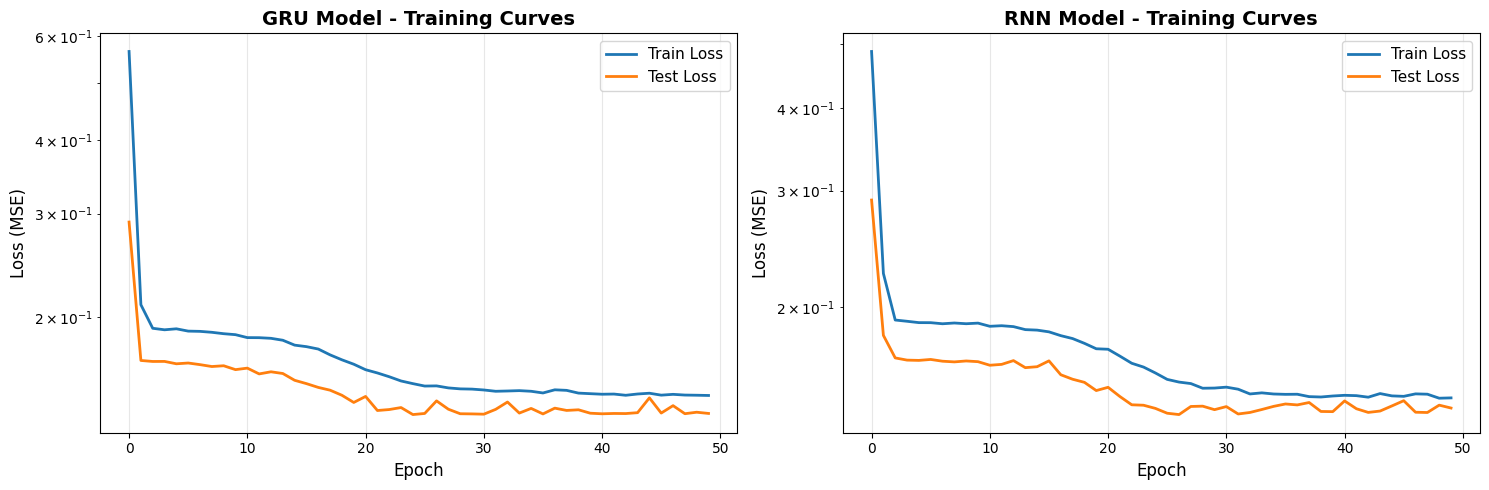

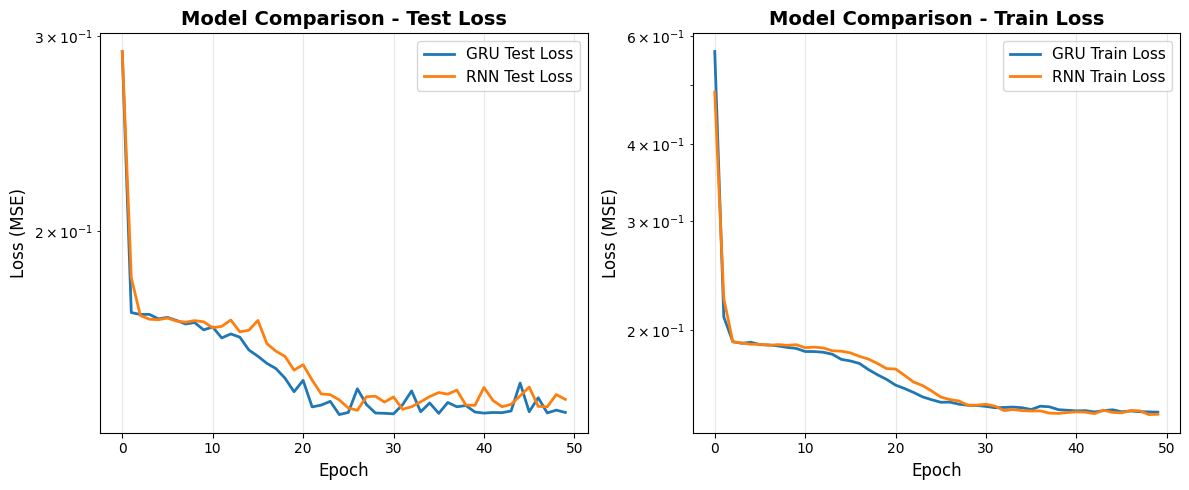

In [23]:
# Plot training curves
plt.figure(figsize=(15, 5))

# GRU Training Curves
plt.subplot(1, 2, 1)
plt.plot(gru_train_losses, label='Train Loss', linewidth=2)
plt.plot(gru_test_losses, label='Test Loss', linewidth=2)
plt.title('GRU Model - Training Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# RNN Training Curves
plt.subplot(1, 2, 2)
plt.plot(rnn_train_losses, label='Train Loss', linewidth=2)
plt.plot(rnn_test_losses, label='Test Loss', linewidth=2)
plt.title('RNN Model - Training Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

# Comparison plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gru_test_losses, label='GRU Test Loss', linewidth=2)
plt.plot(rnn_test_losses, label='RNN Test Loss', linewidth=2)
plt.title('Model Comparison - Test Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(gru_train_losses, label='GRU Train Loss', linewidth=2)
plt.plot(rnn_train_losses, label='RNN Train Loss', linewidth=2)
plt.title('Model Comparison - Train Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()


In [24]:
# Evaluate both models
print("\n" + "="*60)
print("EVALUATING GRU MODEL")
print("="*60)
gru_predictions, gru_actuals, gru_metrics = evaluate_model(gru_model, test_loader, y_scaler)

print("\n" + "="*60)
print("EVALUATING RNN MODEL")
print("="*60)
rnn_predictions, rnn_actuals, rnn_metrics = evaluate_model(rnn_model, test_loader, y_scaler)



EVALUATING GRU MODEL

Evaluation Metrics:
MSE: 0.1360
MAE: 0.2718
RMSE: 0.3688

EVALUATING RNN MODEL

Evaluation Metrics:
MSE: 0.1399
MAE: 0.2950
RMSE: 0.3740


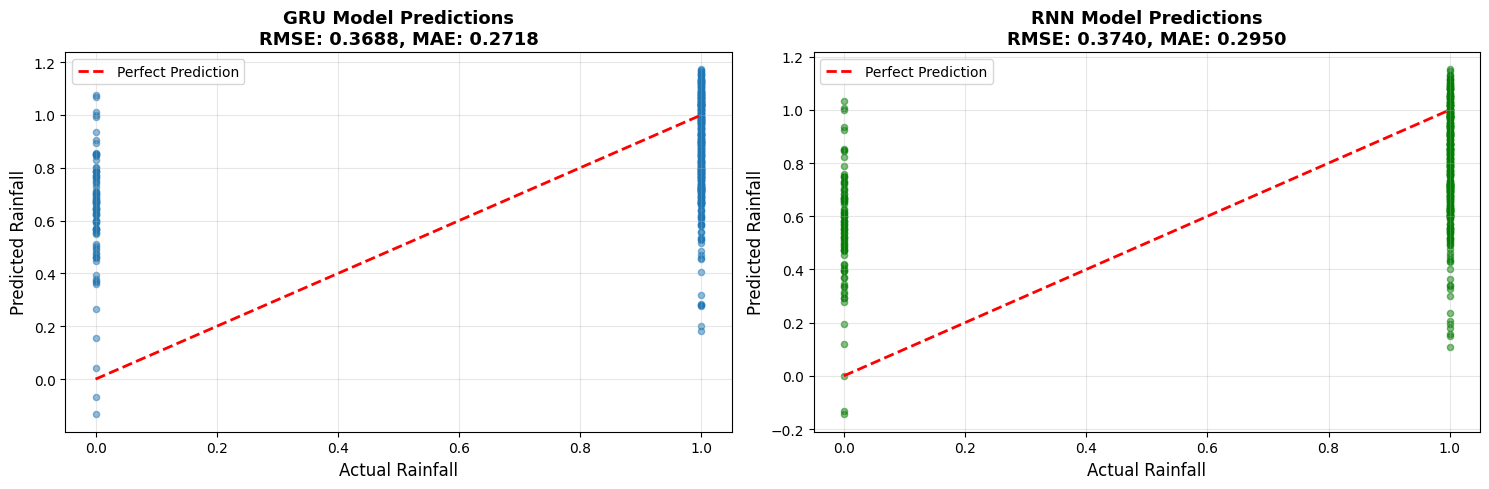

In [25]:
# Plot predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# GRU Predictions
axes[0].scatter(gru_actuals, gru_predictions, alpha=0.5, s=20)
axes[0].plot([gru_actuals.min(), gru_actuals.max()], 
             [gru_actuals.min(), gru_actuals.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rainfall', fontsize=12)
axes[0].set_ylabel('Predicted Rainfall', fontsize=12)
axes[0].set_title(f'GRU Model Predictions\nRMSE: {gru_metrics["rmse"]:.4f}, MAE: {gru_metrics["mae"]:.4f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RNN Predictions
axes[1].scatter(rnn_actuals, rnn_predictions, alpha=0.5, s=20, color='green')
axes[1].plot([rnn_actuals.min(), rnn_actuals.max()], 
             [rnn_actuals.min(), rnn_actuals.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rainfall', fontsize=12)
axes[1].set_ylabel('Predicted Rainfall', fontsize=12)
axes[1].set_title(f'RNN Model Predictions\nRMSE: {rnn_metrics["rmse"]:.4f}, MAE: {rnn_metrics["mae"]:.4f}', 
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained models
torch.save(gru_model.state_dict(), 'gru_rainfall_model.pth')
torch.save(rnn_model.state_dict(), 'rnn_rainfall_model.pth')

# Save scalers for later use
import pickle
with open('scalers.pkl', 'wb') as f:
    pickle.dump({'X_scaler': X_scaler, 'y_scaler': y_scaler}, f)

print("Models and scalers saved successfully!")
print("- gru_rainfall_model.pth")
print("- rnn_rainfall_model.pth")
print("- scalers.pkl")
